Practica Aprenentatge Automàtic - 2020/21

Marco Signaroli

In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

In [2]:
#import data
data = pd.read_csv('/home/marco/Scrivania/airbnb.csv')
data.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11547,https://www.airbnb.com/rooms/11547,20200919153121,2020-09-21,My home at the beach,"Sun, joy, relax, quality, beach & peace.<br />...",NaN,https://a0.muscache.com/pictures/494126/8c151b...,42942,https://www.airbnb.com/users/show/42942,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.93
1,100831,https://www.airbnb.com/rooms/100831,20200919153121,2020-09-21,HOUSE IN MALLORCA - WiFi(ET-3045),<b>The space</b><br />House situated in a quie...,NaN,https://a0.muscache.com/pictures/675527/72b329...,529151,https://www.airbnb.com/users/show/529151,...,10.0,10.0,10.0,ETV-3045,t,1,1,0,0,1.47
2,105891,https://www.airbnb.com/rooms/105891,20200919153121,2020-09-20,VILLAGE HOUSE WITH POOL: IDEAL FOR FAMILIES,The house is a street on the outskirts of the ...,The village's population does not reach two th...,https://a0.muscache.com/pictures/1036816/f36ce...,549192,https://www.airbnb.com/users/show/549192,...,10.0,9.0,10.0,ETV/6127,t,2,2,0,0,0.14


In [3]:
#exploring data
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

A: selecting relevant variables

In [4]:
#selecting variables
reduced_data = data[["host_is_superhost","latitude","longitude",
      "amenities", "instant_bookable",
      "review_scores_value",
      "reviews_per_month", "license",
      "accommodates","bedrooms","beds","price","property_type",
      "room_type","bathrooms_text","minimum_nights","host_identity_verified"]]

reduced_data.dtypes

host_is_superhost          object
latitude                  float64
longitude                 float64
amenities                  object
instant_bookable           object
review_scores_value       float64
reviews_per_month         float64
license                    object
accommodates                int64
bedrooms                  float64
beds                      float64
price                      object
property_type              object
room_type                  object
bathrooms_text             object
minimum_nights              int64
host_identity_verified     object
dtype: object

B: first data exploration

<AxesSubplot:>

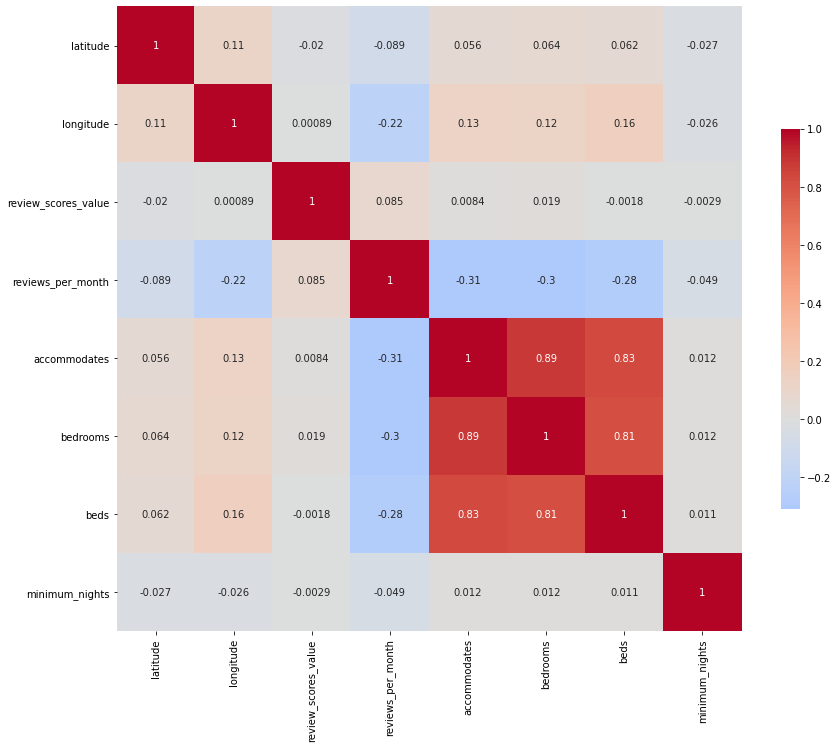

In [5]:
#exploring relevant variables
corr = reduced_data.corr()
f, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": .5}, annot=True, ax=ax)

C: data preparation

In [6]:
#prapare data
adjusted_data = pd.DataFrame().reindex_like(reduced_data)

In [7]:
#1_t/f:   host_is_superhost, instant_bookable, host_identity_verified
reduced_data[['host_is_superhost', 'instant_bookable', 'host_identity_verified']].head()

def bool_to_bin (data):
        if data is 't':
            out = 1
        else:
            out = 0
        return out 
for i in range(len(reduced_data)):
    adjusted_data['host_is_superhost'][i] = bool_to_bin(reduced_data['host_is_superhost'][i])
    adjusted_data['instant_bookable'][i] = bool_to_bin(reduced_data['instant_bookable'][i])    
    adjusted_data['host_identity_verified'][i] = bool_to_bin(reduced_data['host_identity_verified'][i]) 
    
adjusted_data[['host_is_superhost', 'instant_bookable', 'host_identity_verified']].head()

,host_is_superhost,instant_bookable,host_identity_verified
0,0.0,0.0,1.0
1,0.0,1.0,1.0
2,1.0,1.0,1.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [8]:
#2_count elements: amenities
reduced_data[['amenities']].head()

for i in range(len(reduced_data)):
    adjusted_data['amenities'][i] = (reduced_data['amenities'][i].count(","))+1
    
adjusted_data[['amenities']].head()

,amenities
0,23.0
1,20.0
2,35.0
3,10.0
4,7.0


In [9]:
#3_nan/no nan: license
reduced_data[['license']].head()

def some_to_bin (data):
        if pd.isnull(data):
            out = 0
        else:
            out = 1
        return out
for i in range(len(reduced_data)):
    adjusted_data['license'][i] = some_to_bin(reduced_data['license'][i])

adjusted_data[['license']].head()

,license
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0


In [10]:
#4_delete $: price
reduced_data[['price']].head()

for i in range(len(reduced_data)):
    valore = reduced_data["price"][i].replace(",","")
    valore = float(valore[1:])
    adjusted_data['price'][i] = valore
    
adjusted_data[['price']].head()

,price
0,89.0
1,175.0
2,140.0
3,200.0
4,110.0


In [11]:
#5_keep the number: bathrooms_text
reduced_data[['bathrooms_text']].head()

for i in range(len(reduced_data)):
    try:
        val = reduced_data['bathrooms_text'][i].split(' ')
        val = float(val[0])
        adjusted_data['bathrooms_text'][i] = val
    except:
        #print(reduced_data['bathrooms_text'][i])
        adjusted_data['bathrooms_text'][i] = 0.5  #spiega
        
adjusted_data[['bathrooms_text']].head()

,bathrooms_text
0,1.0
1,3.0
2,2.0
3,1.0
4,1.0


In [12]:
#6_keep unchanged: latitude, longitude, review_scores_value, 
                  #reviews_per_month, accommodates, bedrooms, beds,
                  #minimum_nights
for i in range(len(reduced_data)):
    adjusted_data['latitude'][i] = reduced_data['latitude'][i]
    adjusted_data['longitude'][i] = reduced_data['longitude'][i]
    adjusted_data['review_scores_value'][i] = reduced_data['review_scores_value'][i]
    adjusted_data['reviews_per_month'][i] = reduced_data['reviews_per_month'][i]
    adjusted_data['accommodates'][i] = reduced_data['accommodates'][i]
    adjusted_data['bedrooms'][i] = reduced_data['bedrooms'][i]
    adjusted_data['beds'][i] = reduced_data['beds'][i]
    adjusted_data['minimum_nights'][i] = reduced_data['minimum_nights'][i]

In [13]:
#7_reducing number of categories: property_type, room_type
print(reduced_data['room_type'].nunique())
print(reduced_data['property_type'].nunique())

4
74


In [14]:
for i in range(len(reduced_data)):
    adjusted_data['room_type'][i] = reduced_data['room_type'][i] 
    
reduced_data['property_type'] = reduced_data['property_type'].str.lower() 
for i in range(len(reduced_data)):
    k = reduced_data['property_type'][i]
    if 'villa' in k:
        adjusted_data['property_type'][i] = "villa"
    elif 'house' in k or 'casa' in k or 'home' in k:
        adjusted_data['property_type'][i] = "house"
    elif 'apartment' in k or 'condominium' in k or 'loft' in k or 'floor' in k:
        adjusted_data['property_type'][i] = "apartment"
    elif 'cottage' in k or 'chalet' in k:
        adjusted_data['property_type'][i] = "chalet"
    elif 'boat' in k or 'cabin' in k:
        adjusted_data['property_type'][i] = "boat"
    elif 'castle' in k or 'island' in k:
        adjusted_data['property_type'][i] = "luxury"
    elif 'camper' in k:
        adjusted_data['property_type'][i] = "camper"
    elif 'hotel' in k or 'resort' in k or 'suite' in k:
        adjusted_data['property_type'][i] = "good hotel"
    elif 'farm' in k or 'nature' in k:
        adjusted_data['property_type'][i] = "farm"
    elif 'hostel' in k or 'bed' in k or 'bungalow' in k:
        adjusted_data['property_type'][i] = "bad hotel"
    else:
        adjusted_data['property_type'][i] = 'to drop'
adjusted_data = adjusted_data[adjusted_data.property_type != 'to drop']

print(adjusted_data['room_type'].nunique())
print(adjusted_data['property_type'].nunique())

/home/marco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/marco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/marco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

4
10


In [15]:
#check the adjusted dataset untill now
adjusted_data.head()

,host_is_superhost,latitude,longitude,amenities,instant_bookable,review_scores_value,reviews_per_month,license,accommodates,bedrooms,beds,price,property_type,room_type,bathrooms_text,minimum_nights,host_identity_verified
0,0.0,39.51888,2.48182,23.0,0.0,10.0,0.93,0.0,2.0,1.0,1.0,89.0,apartment,Entire home/apt,1.0,5.0,1.0
1,0.0,39.76347,3.16255,20.0,1.0,10.0,1.47,1.0,8.0,4.0,7.0,175.0,house,Entire home/apt,3.0,7.0,1.0
2,1.0,39.66044,3.07165,35.0,1.0,10.0,0.14,1.0,6.0,3.0,4.0,140.0,house,Entire home/apt,2.0,6.0,1.0
3,0.0,39.61600,3.30121,10.0,0.0,9.0,0.09,1.0,4.0,2.0,4.0,200.0,villa,Entire home/apt,1.0,5.0,1.0
4,0.0,39.56478,2.60333,7.0,1.0,NaN,NaN,0.0,2.0,1.0,2.0,110.0,apartment,Private room,1.0,2.0,0.0


In [16]:
adjusted_data.dtypes

host_is_superhost         float64
latitude                  float64
longitude                 float64
amenities                 float64
instant_bookable          float64
review_scores_value       float64
reviews_per_month         float64
license                   float64
accommodates              float64
bedrooms                  float64
beds                      float64
price                     float64
property_type              object
room_type                  object
bathrooms_text            float64
minimum_nights            float64
host_identity_verified    float64
dtype: object

D: filling missing values

In [17]:
#fill nans
adjusted_data.isna().sum()

host_is_superhost            0
latitude                     0
longitude                    0
amenities                    0
instant_bookable             0
review_scores_value       6656
reviews_per_month         6432
license                      0
accommodates                 0
bedrooms                   273
beds                        97
price                        0
property_type                0
room_type                    0
bathrooms_text               0
minimum_nights               0
host_identity_verified       0
dtype: int64

In [18]:
#fill with value (0): reviews_per_month
adjusted_data['reviews_per_month'] = adjusted_data['reviews_per_month'].fillna(0)

In [19]:
#fill with median: review_scores_value
print('review_scores_value:', adjusted_data['review_scores_value'].min())
review_min = adjusted_data['review_scores_value'].min()
review_max = adjusted_data['review_scores_value'].max()
adjusted_data['review_scores_value'] = adjusted_data['review_scores_value'].fillna((review_max-review_min)/2)

review_scores_value: 2.0


In [20]:
#fill with mean: bedrooms, beds
print('bedrooms:', adjusted_data['bedrooms'].mean())
print('beds:', adjusted_data['beds'].mean())
adjusted_data['bedrooms'] = adjusted_data['bedrooms'].fillna(round(adjusted_data['bedrooms'].mean()))
adjusted_data['beds'] = adjusted_data['beds'].fillna(round(adjusted_data['beds'].mean()))

bedrooms: 2.9540442237746087
beds: 4.358861519117563


In [21]:
adjusted_data.isna().sum()

host_is_superhost         0
latitude                  0
longitude                 0
amenities                 0
instant_bookable          0
review_scores_value       0
reviews_per_month         0
license                   0
accommodates              0
bedrooms                  0
beds                      0
price                     0
property_type             0
room_type                 0
bathrooms_text            0
minimum_nights            0
host_identity_verified    0
dtype: int64

E: second data exploration

<AxesSubplot:>

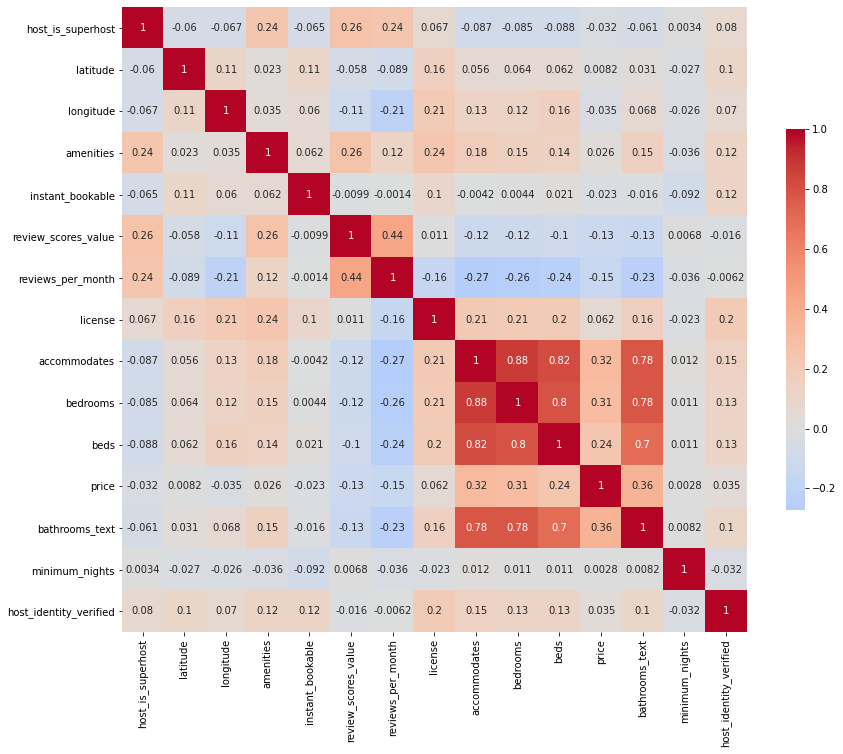

In [22]:
corr = adjusted_data.corr()
f, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": .5}, annot=True, ax=ax)

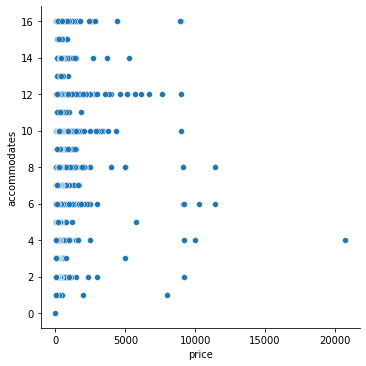

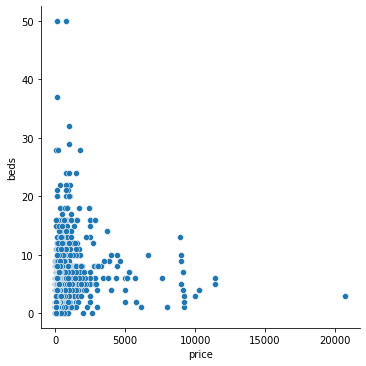

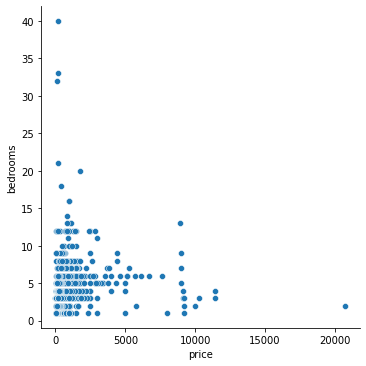

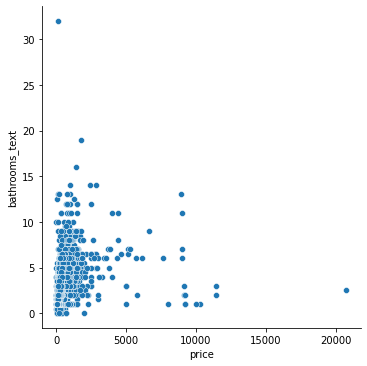

In [24]:
#most correlated variables with "price"
sns.relplot(x="price", y="accommodates", data=adjusted_data);
sns.relplot(x="price", y="beds", data=adjusted_data);
sns.relplot(x="price", y="bedrooms", data=adjusted_data);
sns.relplot(x="price", y="bathrooms_text", data=adjusted_data);

In [25]:
adjusted_data.describe()

,host_is_superhost,latitude,longitude,amenities,instant_bookable,review_scores_value,reviews_per_month,license,accommodates,bedrooms,beds,price,bathrooms_text,minimum_nights,host_identity_verified
count,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000,17594.000000
mean,0.192566,39.657635,2.994211,23.955269,0.644993,7.221951,0.390255,0.649596,5.860407,2.954757,4.356883,244.500497,2.289985,4.342219,0.835626
std,0.394326,0.165600,0.246061,9.806135,0.478529,2.640604,0.686753,0.477110,2.727066,1.508459,2.554784,410.096647,1.362995,12.606088,0.370625
min,0.000000,39.301970,2.346500,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,39.543480,2.797390,16.000000,0.000000,4.000000,0.000000,0.000000,4.000000,2.000000,3.000000,110.000000,1.000000,1.000000,1.000000
50%,0.000000,39.670415,3.047455,23.000000,1.000000,9.000000,0.110000,1.000000,6.000000,3.000000,4.000000,179.000000,2.000000,4.000000,1.000000
75%,0.000000,39.797420,3.145245,31.000000,1.000000,10.000000,0.500000,1.000000,8.000000,4.000000,6.000000,275.000000,3.000000,6.000000,1.000000
max,1.000000,39.930650,3.475520,65.000000,1.000000,10.000000,13.900000,1.000000,16.000000,40.000000,50.000000,20736.000000,32.000000,1124.000000,1.000000


F: one hot encoding

In [26]:
#7_categories: one hot encoding (part 2)
categorical_cols = ['property_type', 'room_type'] 

final_data = pd.get_dummies(adjusted_data, columns = categorical_cols)

In [27]:
final_data.head()

,host_is_superhost,latitude,longitude,amenities,instant_bookable,review_scores_value,reviews_per_month,license,accommodates,bedrooms,...,property_type_chalet,property_type_farm,property_type_good hotel,property_type_house,property_type_luxury,property_type_villa,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0.0,39.51888,2.48182,23.0,0.0,10.0,0.93,0.0,2.0,1.0,...,0,0,0,0,0,0,1,0,0,0
1,0.0,39.76347,3.16255,20.0,1.0,10.0,1.47,1.0,8.0,4.0,...,0,0,0,1,0,0,1,0,0,0
2,1.0,39.66044,3.07165,35.0,1.0,10.0,0.14,1.0,6.0,3.0,...,0,0,0,1,0,0,1,0,0,0
3,0.0,39.61600,3.30121,10.0,0.0,9.0,0.09,1.0,4.0,2.0,...,0,0,0,0,0,1,1,0,0,0
4,0.0,39.56478,2.60333,7.0,1.0,4.0,0.00,0.0,2.0,1.0,...,0,0,0,0,0,0,0,0,1,0


In [28]:
final_data.dtypes

host_is_superhost            float64
latitude                     float64
longitude                    float64
amenities                    float64
instant_bookable             float64
review_scores_value          float64
reviews_per_month            float64
license                      float64
accommodates                 float64
bedrooms                     float64
beds                         float64
price                        float64
bathrooms_text               float64
minimum_nights               float64
host_identity_verified       float64
property_type_apartment        uint8
property_type_bad hotel        uint8
property_type_boat             uint8
property_type_camper           uint8
property_type_chalet           uint8
property_type_farm             uint8
property_type_good hotel       uint8
property_type_house            uint8
property_type_luxury           uint8
property_type_villa            uint8
room_type_Entire home/apt      uint8
room_type_Hotel room           uint8
r

In [29]:
# convert all columns to the float64 dtype
final_data = final_data.astype(np.float64)

final_data.dtypes

host_is_superhost            float64
latitude                     float64
longitude                    float64
amenities                    float64
instant_bookable             float64
review_scores_value          float64
reviews_per_month            float64
license                      float64
accommodates                 float64
bedrooms                     float64
beds                         float64
price                        float64
bathrooms_text               float64
minimum_nights               float64
host_identity_verified       float64
property_type_apartment      float64
property_type_bad hotel      float64
property_type_boat           float64
property_type_camper         float64
property_type_chalet         float64
property_type_farm           float64
property_type_good hotel     float64
property_type_house          float64
property_type_luxury         float64
property_type_villa          float64
room_type_Entire home/apt    float64
room_type_Hotel room         float64
r

In [30]:
final_data.head()

,host_is_superhost,latitude,longitude,amenities,instant_bookable,review_scores_value,reviews_per_month,license,accommodates,bedrooms,...,property_type_chalet,property_type_farm,property_type_good hotel,property_type_house,property_type_luxury,property_type_villa,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0.0,39.51888,2.48182,23.0,0.0,10.0,0.93,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,39.76347,3.16255,20.0,1.0,10.0,1.47,1.0,8.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,39.66044,3.07165,35.0,1.0,10.0,0.14,1.0,6.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,39.61600,3.30121,10.0,0.0,9.0,0.09,1.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,39.56478,2.60333,7.0,1.0,4.0,0.00,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


G: dividing training and testing datasets

In [31]:
#get x and y
target_name = 'price'

df = final_data.sample(frac=1)
X = df.drop(columns=target_name)
y = df[target_name]

#split data
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)

H: model selection, we will try 3 different models (linear regression, decision tree and random forest), tuning the hyperparameters and evaluating their performances using RMSE and MAE.

In [32]:
reg_LR = LinearRegression()
parameters = {"fit_intercept": [True, False],
              "normalize": [True, False],
              "n_jobs": [-2, -1, None, 1, 2]}

gs_reg_LR = GridSearchCV(estimator=reg_LR, param_grid = parameters, cv = 2)

gs_reg_LR.fit(X_train, y_train)

print(gs_reg_LR.best_params_)

df_cv_results = pd.DataFrame(gs_reg_LR.cv_results_)
df_cv_results.head()

{'fit_intercept': True, 'n_jobs': -2, 'normalize': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_n_jobs,param_normalize,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.037860,0.010379,0.026388,0.008785,True,-2,True,"{'fit_intercept': True, 'n_jobs': -2, 'normali...",0.139322,0.167867,0.153595,0.014272,16
1,0.034481,0.000639,0.011651,0.000116,True,-2,False,"{'fit_intercept': True, 'n_jobs': -2, 'normali...",0.139323,0.167925,0.153624,0.014301,1
2,0.036086,0.000271,0.011562,0.000502,True,-1,True,"{'fit_intercept': True, 'n_jobs': -1, 'normali...",0.139322,0.167867,0.153595,0.014272,16
3,0.033360,0.000045,0.011679,0.000273,True,-1,False,"{'fit_intercept': True, 'n_jobs': -1, 'normali...",0.139323,0.167925,0.153624,0.014301,1
4,0.035381,0.000148,0.008211,0.003248,True,None,True,"{'fit_intercept': True, 'n_jobs': None, 'norma...",0.139322,0.167867,0.153595,0.014272,16


In [33]:
reg_DT = DecisionTreeRegressor()
parameters = {"max_depth": range(1, 10),
              "min_samples_split": np.linspace(0.1, 1.0, 10, endpoint=True),
              "min_samples_leaf": np.linspace(0.1, 0.5, 5, endpoint=True)}

gs_reg_DT = GridSearchCV(estimator=reg_DT, param_grid = parameters, cv=5)

gs_reg_DT.fit(X_train, y_train)

print(gs_reg_DT.best_params_)

df_cv_results = pd.DataFrame(gs_reg_DT.cv_results_)
df_cv_results.head()

{'max_depth': 9, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036480,0.048455,0.003518,0.000446,1,0.1,0.1,"{'max_depth': 1, 'min_samples_leaf': 0.1, 'min...",0.060094,0.091313,0.090925,0.106361,0.086873,0.087113,0.015052,84
1,0.011728,0.000122,0.003869,0.001017,1,0.1,0.2,"{'max_depth': 1, 'min_samples_leaf': 0.1, 'min...",0.060094,0.091313,0.090925,0.106361,0.086873,0.087113,0.015052,83
2,0.011502,0.000064,0.002898,0.000075,1,0.1,0.3,"{'max_depth': 1, 'min_samples_leaf': 0.1, 'min...",0.060094,0.091313,0.090925,0.106361,0.086873,0.087113,0.015052,65
3,0.011484,0.000102,0.002950,0.000054,1,0.1,0.4,"{'max_depth': 1, 'min_samples_leaf': 0.1, 'min...",0.060094,0.091313,0.090925,0.106361,0.086873,0.087113,0.015052,65
4,0.011513,0.000223,0.002887,0.000059,1,0.1,0.5,"{'max_depth': 1, 'min_samples_leaf': 0.1, 'min...",0.060094,0.091313,0.090925,0.106361,0.086873,0.087113,0.015052,84


In [34]:
reg_RF = RandomForestRegressor()
parameters = {"max_depth": range(1, 10),
              "n_estimators": [10,20,30],
              "max_features": ["auto","sqrt","log2"]}

gs_reg_RF = GridSearchCV(estimator=reg_RF, param_grid = parameters, cv = 2)

gs_reg_RF.fit(X_train, y_train)

print(gs_reg_RF.best_params_)

df_cv_results = pd.DataFrame(gs_reg_RF.cv_results_)
df_cv_results.head()

{'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 30}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069930,0.023743,0.006220,0.000044,1,auto,10,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.077221,0.126456,0.101839,0.024617,69
1,0.089163,0.006550,0.006504,0.000159,1,auto,20,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.073551,0.131581,0.102566,0.029015,68
2,0.116366,0.000464,0.007527,0.000050,1,auto,30,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.058898,0.129158,0.094028,0.035130,72
3,0.023164,0.000175,0.004838,0.000012,1,sqrt,10,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.071535,0.082458,0.076997,0.005462,74
4,0.044731,0.003372,0.006807,0.000485,1,sqrt,20,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.038643,0.081058,0.059850,0.021208,79


In [43]:
reg_LR2 = LinearRegression(fit_intercept=True, n_jobs=-2, normalize=False)
reg_DT2 = DecisionTreeRegressor(max_depth=9, min_samples_leaf=0.1, min_samples_split=0.2)
reg_RF2 = RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=30)

reg_LR2.fit(X_train, y_train)
reg_DT2.fit(X_train, y_train)
reg_RF2.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=30)

In [44]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def MAE(y_true, y_pred):
    return np.abs((y_true - y_pred)).mean()

In [45]:
in_sample_error_LR = RMSE(y_train, reg_LR2.predict(X_train))
in_sample_error_DT = RMSE(y_train, reg_DT2.predict(X_train))
in_sample_error_RF = RMSE(y_train, reg_RF2.predict(X_train))
print('In RMSE for LR: {e} '.format(e= round(in_sample_error_LR, 2)))
print('In RMSE for DT: {e}'.format(e=round(in_sample_error_DT, 2)))
print('In RMSE for RF: {e} '.format(e= round(in_sample_error_RF, 2)))

out_sample_error_LR = RMSE(y_test, reg_LR2.predict(X_test))
out_sample_error_DT = RMSE(y_test, reg_DT2.predict(X_test))
out_sample_error_RF = RMSE(y_test, reg_RF2.predict(X_test))
print('Out RMSE for LR: {e}'.format(e= round(out_sample_error_LR, 2)))
print('Out RMSE for DT: {e}'.format(e=round(out_sample_error_DT, 2)))
print('Out RMSE for RF: {e}'.format(e= round(out_sample_error_RF, 2)))

In RMSE for LR: 372.08 
In RMSE for DT: 384.96
In RMSE for RF: 265.57 
Out RMSE for LR: 385.69
Out RMSE for DT: 398.03
Out RMSE for RF: 368.61


In [46]:
in_sample_error_LR = MAE(y_train, reg_LR2.predict(X_train))
in_sample_error_DT = MAE(y_train, reg_DT2.predict(X_train))
in_sample_error_RF = MAE(y_train, reg_RF2.predict(X_train))
print('In MAE for LR: {e} '.format(e= round(in_sample_error_LR, 2)))
print('In MAE for DT: {e}'.format(e=round(in_sample_error_DT, 2)))
print('In MAE for RF: {e} '.format(e= round(in_sample_error_RF, 2)))

out_sample_error_LR = MAE(y_test, reg_LR2.predict(X_test))
out_sample_error_DT = MAE(y_test, reg_DT2.predict(X_test))
out_sample_error_RF = MAE(y_test, reg_RF2.predict(X_test))
print('Out MAE for LR: {e}'.format(e= round(out_sample_error_LR, 2)))
print('Out MAE for DT: {e}'.format(e=round(out_sample_error_DT, 2)))
print('Out MAE for RF: {e}'.format(e= round(out_sample_error_RF, 2)))

In MAE for LR: 112.05 
In MAE for DT: 113.08
In MAE for RF: 84.41 
Out MAE for LR: 114.41
Out MAE for DT: 115.17
Out MAE for RF: 103.12


I: pipelines with scaling. With the best model (random forest, according to both the RMSE and the MAE), we try to scale data with 2 different techniques (standard scaler and min max scaler).

In [39]:
scaling_step = ('scaler', StandardScaler())
model_step = ('clf', RandomForestRegressor())

steps = [scaling_step, model_step]
pipe = Pipeline(steps)

p0 = pipe.fit(X_train, y_train)

out_sample_error_RF = RMSE(y_test, p0.predict(X_test))
print('Out RMSE for RF: {e}'.format(e= round(out_sample_error_RF, 2)))
out_sample_error_RF = MAE(y_test, p0.predict(X_test))
print('Out MAE for RF: {e}'.format(e= round(out_sample_error_RF, 2)))

Out RMSE for RF: 366.03
Out MAE for RF: 100.32


In [40]:
imputation_step = ('imputer', SimpleImputer())
model_step = ('clf', RandomForestRegressor())

steps = [imputation_step, model_step]
pipe = Pipeline(steps)

p1 = pipe.fit(X_train, y_train)

out_sample_error_RF = RMSE(y_test, p1.predict(X_test))
print('Out RMSE for RF: {e}'.format(e= round(out_sample_error_RF, 2)))
out_sample_error_RF = MAE(y_test, p1.predict(X_test))
print('Out MAE for RF: {e}'.format(e= round(out_sample_error_RF, 2)))

Out RMSE for RF: 368.71
Out MAE for RF: 101.74


In [41]:
imputation_step = ('imputer', SimpleImputer())
scaling_step = ('scaler', StandardScaler())
model_step = ('clf', RandomForestRegressor())

steps = [imputation_step, scaling_step, model_step]
pipe = Pipeline(steps)

p2 = pipe.fit(X_train, y_train)

out_sample_error_RF = RMSE(y_test, p2.predict(X_test))
print('Out RMSE for RF: {e}'.format(e= round(out_sample_error_RF, 2)))
out_sample_error_RF = MAE(y_test, p2.predict(X_test))
print('Out MAE for RF: {e}'.format(e= round(out_sample_error_RF, 2)))

Out RMSE for RF: 368.84
Out MAE for RF: 102.04


In [47]:
imputation_step = ('imputer', SimpleImputer())
scaling_step = ('scaler', MinMaxScaler())
model_step = ('clf', RandomForestRegressor())

steps = [imputation_step, scaling_step, model_step]
pipe = Pipeline(steps)

p3 = pipe.fit(X_train, y_train)

out_sample_error_RF = RMSE(y_test, p3.predict(X_test))
print('Out RMSE for LR: {e}'.format(e= round(out_sample_error_RF, 2)))
out_sample_error_RF = MAE(y_test, p3.predict(X_test))
print('Out MAE for LR: {e}'.format(e= round(out_sample_error_RF, 2)))

Out RMSE for LR: 370.86
Out MAE for LR: 101.9


J: cross validation. We found that scaling data doesn't affect the accuracy of the predictions, so we try to get better results using cross validation.

In [48]:
rmse_scorer = make_scorer(RMSE, greater_is_better=False)

RF_scores = cross_val_score(estimator=RandomForestRegressor(), X=final_data, y=final_data.price, cv=5, scoring=rmse_scorer)

print('RMSE for RF: {m} +- {s}'.format(m=-round(RF_scores.mean(), 2),
                                       s=round(RF_scores.std(),2)))

RMSE for RF: 65.9 +- 56.99


This last model, trained with cross vaidation is the best found.